Video Game is a fun business, and also full of amazing success stories. However, like film industry, it's a hit or miss in terms of investment. It's not unusual that publishers/developers invest significantly but didn't receive the expected return. APB: All Points Bulletin, published on 2010 by Electronic Arts, cost 100 millions US dollar to development, and ended up saling the game to a different company for around 2 million US dollar, becasue the sales of the game is so bad. 

There are many factors involved to determine if a game is success or not. This project, I would like to explore the impact from review scores to the game sales, and see if we can have a model to predict sales by review score, and/or have a model to predict sales from different regions. The technique used here could be beneficial to other business. For example. with sufficient data, we can predict the sales of a Sage ERP module by review score, or predict sales from one region to another region.

Dataset for this project is from Kaggle (https://www.kaggle.com/xtyscut/video-games-sales-as-at-22-dec-2016csv?select=Video_Games_Sales_as_at_22_Dec_2016.csv). The data combines with VGSales data and review score from Metacritic, which is perfect for this project. However, the data is not consistent and data clean up is needed for further processing. 

In [1]:
# common imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# read in the dataset
filepath = Path.joinpath(Path.cwd().parent, 'data', 'Video_Games_Sales_as_at_22_Dec_2016.csv')
games = pd.read_csv(filepath)

In [3]:
# data set info
games.shape

(16719, 16)

In [4]:
# what is the data look like
games.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# unique value for each columns
games.nunique()

Name               11562
Platform              31
Year_of_Release       39
Genre                 12
Publisher            581
NA_Sales             402
EU_Sales             307
JP_Sales             244
Other_Sales          155
Global_Sales         629
Critic_Score          82
Critic_Count         106
User_Score            96
User_Count           888
Developer           1696
Rating                 8
dtype: int64

In [6]:
# check null data
games.isnull().sum().sort_values(ascending=False).head(10)

User_Count         9129
Critic_Score       8582
Critic_Count       8582
Rating             6769
User_Score         6704
Developer          6623
Year_of_Release     269
Publisher            54
Name                  2
Genre                 2
dtype: int64

# many missing data. Do the following the clean up the data
1. Drop columns that are unrelevant to this analysis ('Developer', 'User_Count', 'Critic_Count')
2. Fill in 'Unknown' for 'Rating'
3. Fill in 'Other' for Publisher
3. Make datatype consistent for modeling
4. Fill nan score value with mean value for the score columns
5. Drop rest of the nan value

In [7]:
# 1. drop columns
games.drop(['Developer'] ,inplace =True, axis =1)
games.drop(['Critic_Count'] ,inplace =True, axis =1)
games.drop(['User_Count'] ,inplace =True, axis =1)
games.drop(['Name'], inplace=True, axis = 1)
# drop a bit more for dummy analysis
#games.drop(['Rating'], inplace=True, axis = 1)
games.drop(['Publisher'], inplace=True, axis = 1)

In [8]:
# check what type of data distribution on Rating
games['Rating'].value_counts()

E       3991
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: Rating, dtype: int64

In [9]:
# 2 and 3 fill default value
# AO has only 1 game, which sales extremly too well (GTA 4), let's put it into M cateogry which was its initial rating
# Also K-A (Kid to Aldut) is the same as E (everyone)
games['Rating'] = games['Rating'].replace("AO", "M")
games['Rating'] = games['Rating'].replace("K-A", "E")
games['Rating'] = games['Rating'].fillna("RP")
#games['Publisher'] = games['Publisher'].fillna("Other")

In [10]:
games['Rating'].value_counts()

RP      6772
E       3994
T       2961
M       1564
E10+    1420
EC         8
Name: Rating, dtype: int64

In [11]:
# 4.1 check column datatype
games.dtypes

Platform            object
Year_of_Release    float64
Genre               object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

In [12]:
games['Rating'].unique()

array(['E', 'RP', 'M', 'T', 'E10+', 'EC'], dtype=object)

While Critic_Score is float64, User_Score is an object. Convert User_Score to float64. Before that, let's check what's in User_Score first, some values might not be convertable

In [13]:
# 4.2 check what User_Score could be
games['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Other than nan, 'tbd' is a non-numeric value. change 'tbd' to 'nan' as well so we can fill in some meanful value for both later on

In [14]:
# 4.3 Replace'tbd' with nan
games['User_Score'] = games['User_Score'].replace('tbd', np.nan)

In [15]:
# 4.4 User score is not numeric type, change it and scale it to the samem scale with Critic_Score
games['User_Score'] = games['User_Score'].astype('float64')

In [16]:
# 5.1 check null data
games.isnull().sum().sort_values(ascending=False).head(10)

User_Score         9129
Critic_Score       8582
Year_of_Release     269
Genre                 2
Platform              0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
dtype: int64

Many Null value in Critic_Score and User_Score, fill in column's mean 

In [17]:
# 5.2 fill in mean value
games['User_Score'].fillna(value=games['User_Score'].mean(), inplace=True)
games['Critic_Score'].fillna(value=games['Critic_Score'].mean(), inplace=True)

In [18]:
# 6 Still a few null value in Name, Genre and Year_of_Release, but not that much compared to the whole dataset. Drop them
games.dropna(inplace=True)

In [19]:
#check null again, data is clean
games.isnull().sum().sort_values(ascending=False).head(10)

Platform           0
Year_of_Release    0
Genre              0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
User_Score         0
dtype: int64

<AxesSubplot:>

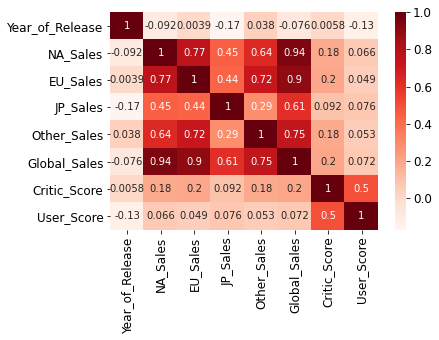

In [20]:
# check correlation between features
sns.heatmap(games.corr(),annot=True,cmap='Reds', fmt='.2g')

From the heat map, these have strong correlations
- NA_SALES and EU_SALES
- NA_SALES and Other_SALES
- Global Sales and all other type of Sales (this makes sense as Global Sales are the total of others). No need to further model this
- Critic_Score and Global Sales (not very strong, but let's still build a model based on that to predict sales
User_Score doesn't seem to have too much correlation with sales

[(0.0, 17.5)]

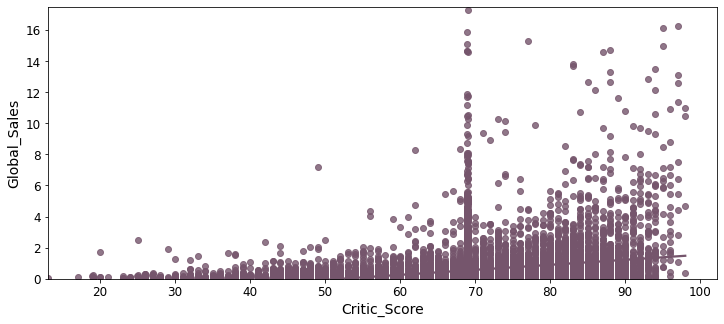

In [21]:
# Visualize the correlation between Critic_Score and Global_Sales
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=games, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

[(0.0, 17.5)]

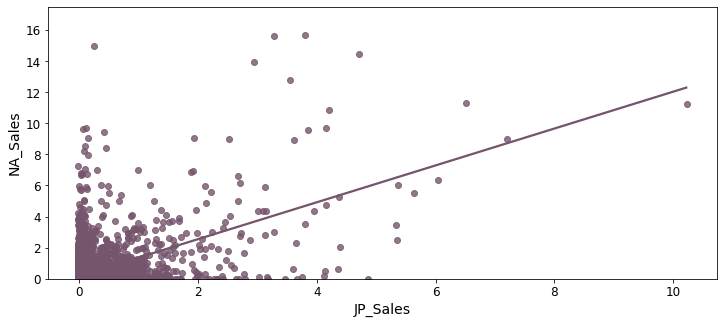

In [22]:
# Visualize the correlation between North American Sales and Europe Sales
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="JP_Sales", y="NA_Sales", data=games, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

# By that, build two models:
- Based on sales in North America, predict sales in Europe
- Based on Critic Score, predict global sales

In [23]:
games_full = pd.get_dummies(games)

In [24]:
games_full.head()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Platform_2600,Platform_3DO,...,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_E,Rating_E10+,Rating_EC,Rating_M,Rating_RP,Rating_T
0,2006.0,41.36,28.96,3.77,8.45,82.53,76.000000,8.000000,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1985.0,29.08,3.58,6.81,0.77,40.24,68.967679,7.125046,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2008.0,15.68,12.76,3.79,3.29,35.52,82.000000,8.300000,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2009.0,15.61,10.93,3.28,2.95,32.77,80.000000,8.000000,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1996.0,11.27,8.89,10.22,1.00,31.37,68.967679,7.125046,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
# encode categories data
#games['Platform'], label_platform = pd.factorize(games['Platform'])
#games['Genre'], label_genre = pd.factorize(games['Genre'])
#games['Rating'], label_rating = pd.factorize(games['Rating'])


In [26]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#df = pd.DataFrame({
#  "A" : [0, 1, 2, 3, 4],
#  "B" : [25, 50, 75, 100, 125]})
#df[["A", "B"]] = scaler.fit_transform(df[["A", "B"]])
#games[["Platform"]] = scaler.fit_transform(games[['Platform']])

In [27]:
features = ['Critic_Score', 'User_Score']
target = "Global_Sales"

In [28]:
# split data into feature and sale. 
#y_critic = games[target].copy()
y_critic = games["Global_Sales"].copy()
#X_critic = games[features].copy()
#X_critic = games.drop(['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales'], axis = 1)
X_critic = games_full.drop(['Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales'], axis = 1)

In [29]:
# Now, split both X and y data into training and testing sets.
X_critic_train, X_critic_test, y_critic_train, y_critic_test = train_test_split(X_critic, y_critic, 
                                       test_size=0.2, 
                                       random_state=42)

In [30]:
# Create a local instance of the sklearn class
lin_reg_critic = LinearRegression()

In [31]:
# Fit your instance to the training dataset
lin_reg_critic.fit(X_critic_train, y_critic_train)

LinearRegression()

In [32]:
lin_reg_critic_score_train = lin_reg_critic.score(X_critic_test, y_critic_test)
lin_reg_critic_score_test = lin_reg_critic.score (X_critic_train, y_critic_train)

In [33]:
print("Training score: ",lin_reg_critic_score_train)
print("Testing score: ",lin_reg_critic_score_test)

Training score:  0.04847606045569386
Testing score:  0.13088303066649187


In [34]:
# Make predictions on the testing dataset
y_critic_preds = lin_reg_critic.predict(X_critic_test)

In [35]:
# Print the coefficients.
print(lin_reg_critic.intercept_)
print(lin_reg_critic.coef_)

106.01515362882233
[-5.36038448e-02  3.75166085e-02 -8.00278300e-02 -8.38067730e-01
 -7.63213573e-01  4.76428219e-01 -5.25386841e-01  1.40705967e-01
  1.98565465e+00 -2.15058698e-01 -3.00998205e-01  9.74286420e-02
  7.24420524e-15 -3.67787039e-02  1.14997790e+00 -8.14854510e-01
 -3.04798430e-01 -1.33226763e-15 -1.48174003e-01  6.23522631e-02
  3.98085503e-01  6.67889096e-01  2.24756849e-02  1.66198641e-01
 -5.98191492e-01 -5.49847065e-01 -7.27720484e-02 -7.72790953e-01
 -3.77674416e-01  3.71105201e-01  3.58972164e-01  3.99147462e-01
 -3.80162581e-01  4.02347857e-01  5.26675361e-02 -1.61098183e-01
  3.97291344e-02 -3.68312928e-02  3.65054018e-01 -1.56232831e-01
  6.25469259e-02  6.13893486e-02  9.63375948e-02 -2.81716554e-03
 -1.27799657e-01 -1.92945429e-01  5.67357899e-02 -5.81575348e-02
 -9.96244080e-02  3.30971492e-01 -2.07543351e-01 -2.23819884e-02]


In [36]:
feature_imp = pd.DataFrame(zip(X_critic.columns, lin_reg_critic.coef_), columns = ['features', 'coeffs'])
feature_imp=feature_imp.set_index('features')
feature_imp=feature_imp.sort_values('coeffs')
feature_imp

,coeffs
features,
Platform_2600,-8.380677e-01
Platform_NG,-8.148545e-01
Platform_TG16,-7.727910e-01
Platform_3DO,-7.632136e-01
Platform_SAT,-5.981915e-01
Platform_SCD,-5.498471e-01
Platform_DC,-5.253868e-01
Platform_XB,-3.801626e-01
Platform_WS,-3.776744e-01


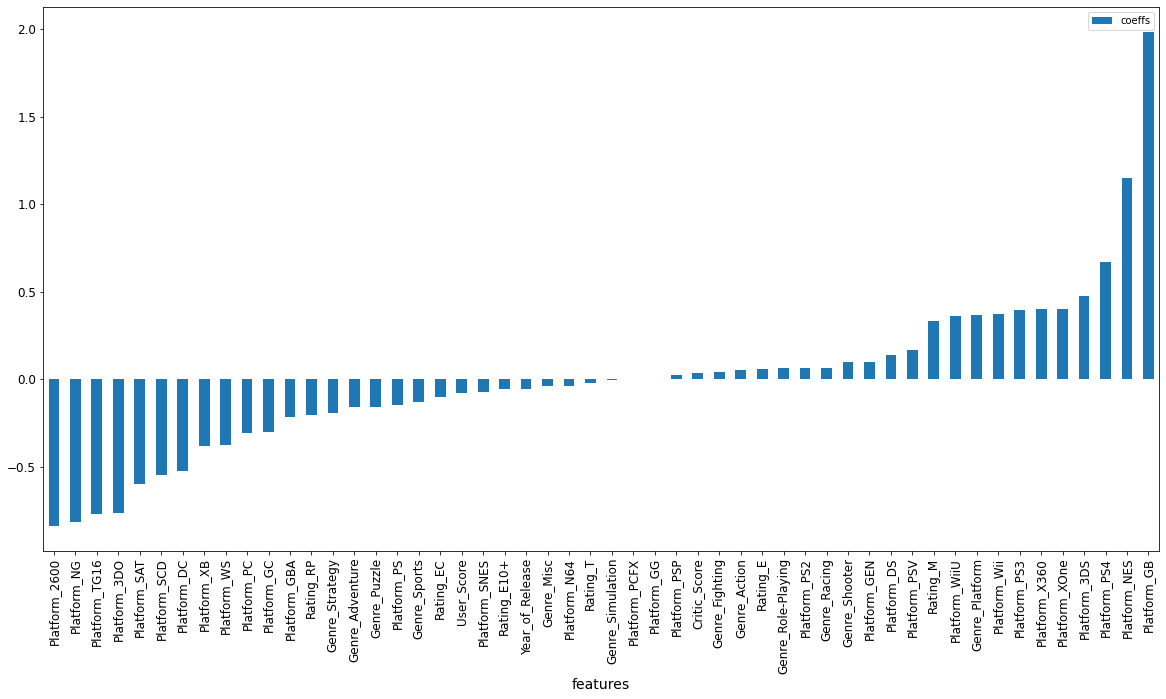

In [37]:
# plot that as a bar chart
feature_imp.plot(kind='bar', figsize=(20,10));

In [38]:
# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_critic_test, y_critic_preds))
print('rmse', np.sqrt(mean_squared_error(y_critic_test, y_critic_preds)))
print('R2', r2_score(y_critic_test, y_critic_preds))

mae 0.5864696883743017
rmse 2.002829955806433
R2 0.04847606045569386


In [ ]:
# try some other data
#m = lin_reg_critic.predict([[30],[80],[99]])
#m

Now a model to predict Europe Sales from North American Sales

In [ ]:
features = ['JP_Sales']
target = ['NA_Sales']

# split data into feature and sale. 
y_EUSales = games[target].copy()
X_EUSales = games[features].copy()

# Now, split both X and y data into training and testing sets.
X_EUSales_train, X_EUSales_test, y_EUSales_train, y_EUSales_test = train_test_split(X_EUSales, y_EUSales, 
                                       test_size=0.2, 
                                       random_state=42)

# Create a local instance of the sklearn class
lin_reg_EUSales = LinearRegression()

# Fit your instance to the training dataset
lin_reg_EUSales.fit(X_EUSales_train, y_EUSales_train)



In [ ]:
# Print the coefficients.
print(lin_reg_EUSales.intercept_)
print(lin_reg_EUSales.coef_)

In [ ]:
# Eu_Sales evaluation
lin_reg_EUSales_score_train = lin_reg_critic.score(X_EUSales_test, y_EUSales_test)
lin_reg_EUSales_score_test = lin_reg_critic.score (X_EUSales_train, y_EUSales_train)

print("Training score: ",lin_reg_EUSales_score_train)
print("Testing score: ",lin_reg_EUSales_score_test)

# Make predictions on the testing dataset
y_EUSales_preds = lin_reg_EUSales.predict(X_EUSales_test)

# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_EUSales_test, y_EUSales_preds))
print('rmse', np.sqrt(mean_squared_error(y_EUSales_test, y_EUSales_preds)))
print('R2', r2_score(y_EUSales_test, y_EUSales_preds))

In [ ]:
# try some other data
m = lin_reg_EUSales.predict([[11.55],[80],[99]])
m

In [ ]:
# try KNN
from sklearn import neighbors
n_neighbors=5
knn_reg=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn_reg.fit(X_train, y_train)

In [ ]:
knn_score_train = knn_reg.score(X_test, y_test)
knn_score_test = knn_reg.score(X_train, y_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

In [ ]:
# Make predictions on the testing dataset
y_preds = knn_reg.predict(X_test)

In [ ]:
m = knn_reg.predict([[30],[80],[90]])

In [ ]:
m

In [ ]:
y_preds

In [ ]:
# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_test, y_preds))
print('rmse', np.sqrt(mean_squared_error(y_test, y_preds)))
print('R2', r2_score(y_test, y_preds))